<a href="https://colab.research.google.com/github/shail2512-lm10/deep_learning_/blob/main/cifar10_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [ ]:
tfds.disable_progress_bar()

In [ ]:
(train_ds, valid_ds), info = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incomplete7AHZ57/cifar10-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incomplete7AHZ57/cifar10-test.tfrecord
Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def normalize(image, label):
  return tf.cast(image, np.float32)/255.0, label

In [ ]:
def augmentation(image, label):
  image = tf.image.flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=32.0/255.0)
  image = tf.image.random_saturation(image, 0.5, 1.5)
  image = tf.cast(image, np.float32)
  image = tf.clip_by_value(image, 0.0, 1.0)
  image = tf.cast(image, np.float32)

  return image, label

In [ ]:

train_ds = train_ds.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(50000)
train_ds = train_ds.map(augmentation, tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
valid_ds = valid_ds.map(normalize, tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.batch(64)
valid_ds = valid_ds.cache()
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
train_ds

<DatasetV1Adapter shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
def resnet_block(input_data, filters, kernel_size):
  x = layers.Conv2D(filters, kernel_size, padding='same')(input_data)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters, kernel_size, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([x, input_data])
  x = layers.Activation('relu')(x)
  x = layers.Dropout(0.2)(x)
  return x

In [ ]:
inputs = tf.keras.Input([32, 32, 3])

In [ ]:
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.MaxPool2D()(x)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = resnet_block(x, 64, 3)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

In [ ]:
resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 32, 32, 64)   18496       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_26[0][0]                  
____________________________________________________________________________________________

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
import os

In [ ]:
def tensorboard_callback():
  logdir = os.path.join("drive/My Drive/logs", datetime.datetime.now().strftime("%d-%m-%Y__%H:%M:%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5)

In [ ]:
tensorboard = tensorboard_callback()

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(5*0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = resnet_model.fit(x = train_ds, epochs=50, callbacks=[tensorboard, early_stopping], validation_data=valid_ds, validation_freq=1)

Epoch 1/50
782/782 [==============================] - 127s 162ms/step - loss: 1.2139 - accuracy: 0.5639 - val_loss: 1.9339 - val_accuracy: 0.4681
Epoch 2/50
782/782 [==============================] - 126s 161ms/step - loss: 0.9064 - accuracy: 0.6783 - val_loss: 1.0445 - val_accuracy: 0.6571
Epoch 3/50
782/782 [==============================] - 126s 161ms/step - loss: 0.7686 - accuracy: 0.7300 - val_loss: 0.8889 - val_accuracy: 0.7002
Epoch 4/50
782/782 [==============================] - 126s 161ms/step - loss: 0.6788 - accuracy: 0.7635 - val_loss: 0.9404 - val_accuracy: 0.7008
Epoch 5/50
782/782 [==============================] - 126s 161ms/step - loss: 0.6100 - accuracy: 0.7865 - val_loss: 0.7334 - val_accuracy: 0.7516
Epoch 6/50
782/782 [==============================] - 125s 160ms/step - loss: 0.5533 - accuracy: 0.8069 - val_loss: 0.7737 - val_accuracy: 0.7487
Epoch 7/50
782/782 [==============================] - 125s 160ms/step - loss: 0.5063 - accuracy: 0.8225 - val_loss: 0.6823 -

In [ ]:
!pip install -q pyyaml h5py

In [ ]:
resnet_model.save('drive/My Drive/models/resnet_1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: drive/My Drive/models/resnet_1/assets


INFO:tensorflow:Assets written to: drive/My Drive/models/resnet_1/assets


In [ ]:
res_model = tf.keras.models.load_model('drive/My Drive/models/resnet_1')

In [ ]:
predictions = res_model.predict(valid_ds)

In [ ]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','sheep','truck']

In [ ]:
def get_prediction_label(prediction_proba):
  return classes[np.argmax(prediction_proba)]

In [ ]:
pred_label = get_prediction_label(predictions[0])

In [ ]:
pred_label

'horse'

In [ ]:
images_ = []
labels_ = []

for image, label in valid_ds.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

In [ ]:
images_[0], labels_[0]

(array([[[0.7058824 , 0.7294118 , 0.7411765 ],
         [0.6313726 , 0.654902  , 0.65882355],
         [0.54901963, 0.57254905, 0.5568628 ],
         ...,
         [0.20392157, 0.21568628, 0.15686275],
         [0.2       , 0.21568628, 0.15686275],
         [0.2       , 0.21176471, 0.15686275]],
 
        [[0.6745098 , 0.69803923, 0.6901961 ],
         [0.5882353 , 0.6117647 , 0.6       ],
         [0.4627451 , 0.49019608, 0.4627451 ],
         ...,
         [0.1764706 , 0.18431373, 0.12941177],
         [0.16862746, 0.1764706 , 0.12156863],
         [0.17254902, 0.1882353 , 0.13333334]],
 
        [[0.6313726 , 0.65882355, 0.627451  ],
         [0.5764706 , 0.60784316, 0.57254905],
         [0.47058824, 0.49803922, 0.4627451 ],
         ...,
         [0.16470589, 0.1882353 , 0.12941177],
         [0.16862746, 0.19607843, 0.13333334],
         [0.18039216, 0.21960784, 0.15294118]],
 
        ...,
 
        [[0.9764706 , 0.9764706 , 0.9764706 ],
         [0.99215686, 0.99215686, 0.99215

'airplane'

In [ ]:
get_prediction_label(predictions[1])

'airplane'

In [ ]:
def plot_predictions(prediction_proba, labels, images, n):
  pred_prob, true_label, image = prediction_proba[n], labels[n], images[n]

  pred_label = get_prediction_label(pred_prob)
  true_label = classes[true_label]

  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.imshow(image)
  plt.xticks()
  plt.yticks()
  plt.title('{} / {:2.0f}% / {}'.format(pred_label, np.max(pred_prob)*100, true_label), color=color)


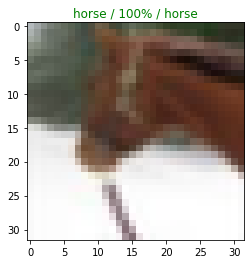

In [ ]:
plot_predictions(predictions, labels_, images_, 0)